## LSTM for google stock price 

#### The goal of this exercise is to use Reccurent Neural Network (RNN) to predict the trend of google stock price. We will use LSTM to train 5 years of the stock price and use the optimized the trend of the first month of 2017. We rely on only the stock data but in reality the trend might be also dependent on other factors or stocks. 

In [16]:
# importing modules 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 

from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout 

In [4]:
#part 1: Data processing 

df_train = pd.read_csv("Google_Stock_Price_Train.csv")
df_test = pd.read_csv("Google_Stock_Price_Test.csv")
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [19]:
# extract the price into numpy array
train_set = df_train.iloc[:, 1:2].values
test_set = df_test.iloc[:, 1:2].values

print(train_set.shape, test_set.shape)

(1258, 1) (20, 1)


In [10]:
# Scaling of train set (normalization is normally recommended for RNN)
scaler = MinMaxScaler(feature_range= (0,1))
train_set_scaled = scaler.fit_transform(train_set)

In [14]:
# organize the data with 60 timesteps (memory range of the model) (Very key for the models performance)
# At each timestep, the RNN will look back the 60 timesteps to lern from the data (It require trial to avoid overfitting)
x_train = []
y_train = []

for i in range(60, train_set.shape[0]):
    x_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])
    
# convert list to np.array    
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)

#reshaping (to include indicator, which is 1)

X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(X_train.shape)
    

(1198, 60)
(1198, 60, 1)


In [18]:
# Part 2 : Building RNN

# Initialising the RNN
reg = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
reg.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
reg.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
reg.add(LSTM(units = 50, return_sequences = True))
reg.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
reg.add(LSTM(units = 50, return_sequences = True))
reg.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
reg.add(LSTM(units = 50))
reg.add(Dropout(0.2))

# Adding the output layer
reg.add(Dense(units = 1))

# Compiling the RNN
reg.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
reg.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 12s 113ms/step - loss: 0.0415
Epoch 2/100
38/38 [==============================] - 4s 114ms/step - loss: 0.0068
Epoch 3/100
38/38 [==============================] - 5s 121ms/step - loss: 0.0063
Epoch 4/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0048
Epoch 5/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0051
Epoch 6/100
38/38 [==============================] - 5s 136ms/step - loss: 0.0044
Epoch 7/100
38/38 [==============================] - 6s 160ms/step - loss: 0.0043
Epoch 8/100
38/38 [==============================] - 5s 142ms/step - loss: 0.0044
Epoch 9/100
38/38 [==============================] - 6s 150ms/step - loss: 0.0045
Epoch 10/100
38/38 [==============================] - 5s 133ms/step - loss: 0.0041
Epoch 11/100
38/38 [==============================] - 5s 139ms/step - loss: 0.0043
Epoch 12/100
38/38 [==============================] - 5s 137ms/step - loss: 0.0045
Epoch 13/100

38/38 [==============================] - 6s 157ms/step - loss: 0.0015
Epoch 100/100
38/38 [==============================] - 6s 153ms/step - loss: 0.0013


In [21]:
# Part 3 (making predictions with the test data)
real_stock_price = test_set

df_all = pd.concat((df_train['Open'], df_test['Open']), axis = 0)

inputs = df_all[len(df_all) - len(df_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = reg.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

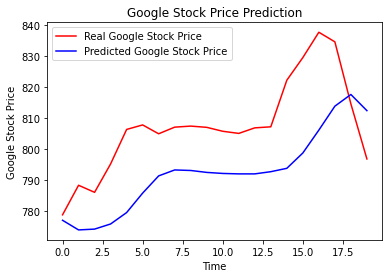

In [22]:
# plotting of predict trend

plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [26]:
# Part 3: Model evaluation
# Since we predict the trend of the price, evaluating RSME would not make much sense, since we check the direction. 
# We want to check if our predictions follow the same directions as the real stock price and we don’t really care 
# whether our predictions are close the real stock price. 
# The predictions could indeed be close but often taking the opposite direction from the real stock price.
# Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 (that is around 800) 
# to get a relative error, as opposed to an absolute error.

from sklearn.metrics import mean_squared_error
import math 

rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(test_set.max())
print(rmse/test_set.max())

837.81
0.022275270884897152
